In [1]:
from SimPEG import Utils
from SimPEG.Utils import mkvc
import SimPEG.PF as PF
import numpy as np
import scipy as sp
import re
import matplotlib.pyplot as plt

In [2]:
workDir = 'C:\\Dianne\\Data\\Public\\GBC_Search\\Phase2\\Mag\\GBCR2018-02-GDB-Magnetics\\'
fname = 'Search_reduced_columns.csv'

In [3]:
fid = open(workDir+fname, 'r')
header = fid.readline()


print(header)

dtaMat=fid.readlines()
fid.close()

altrad_heli,dem,gpsz,mag_tmi,x_nad83_9n,y_nad83_9n



In [5]:
def progress(iter, prog, final):
    """
    progress(iter,prog,final)

    Function measuring the progress of a process and print to screen the %.
    Useful to estimate the remaining runtime of a large problem.

    Created on Dec, 20th 2015

    @author: dominiquef
    """
    arg = np.floor(float(iter)/float(final)*10.)

    if arg > prog:

        print("Done " + str(arg*10) + " %")
        prog = arg

    return prog

dataMat = []
count = -1
for ii, line in enumerate(dtaMat):
    lst = re.findall('\d*\.\d*', line)
    
    if len(lst) == 6:
        dataMat.append([float(i) for i in lst])
        
    count = progress(ii, count, len(dtaMat))

Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %


In [6]:
dataMat = np.vstack(dataMat)

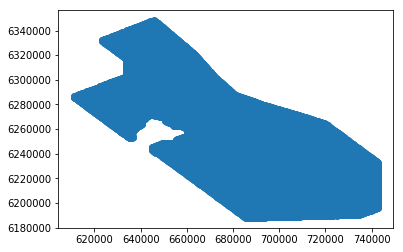

In [7]:
# small = dataMat[::100,:]
# small.shape

# plt.scatter(small[:,4],small[:,5])
# plt.show()

In [9]:
dType = 'XYZ'
method = ('random', 0.1)  #('radius', 100)# #

dFileOut = 'Search_reduced_columns_DwnS100m.dat'

# # SCRIPT STARTS HERE # #
if dType == 'MAG':
    survey = PF.Magnetics.readMagneticsObservations(workDir + '\\' + dFile)
    locXYZ = survey.srcField.rxList[0].locs
elif dType == 'GRAV':
    survey = PF.Gravity.readUBCgravObs(workDir + '\\' + dFile)
    locXYZ = survey.srcField.rxList[0].locs
elif dType == 'XYZ':
#     survey = np.loadtxt(workDir + "\\" + dFile, skiprows=1)
    locXYZ = dataMat[:, 4:]
else:
    assert dType in ['MAG', 'GRAV', 'XYZ'], "dType must be 'MAG' or 'GRAV'"

# Downsample the survey using specified method
assert method[0] in ['radius', 'random'], "Downsample method should be 'radius' or 'random' "


def progress(iter, prog, final):
    """
    progress(iter,prog,final)

    Function measuring the progress of a process and print to screen the %.
    Useful to estimate the remaining runtime of a large problem.

    Created on Dec, 20th 2015

    @author: dominiquef
    """
    arg = np.floor(float(iter)/float(final)*10.)

    if arg > prog:

        print("Done " + str(arg*10) + " %")
        prog = arg

    return prog


if method[0] == 'radius':

    nstn = locXYZ.shape[0]
    # Initialize the filter
    indx = np.ones(nstn, dtype='bool')

    count = -1
    print("Begin filtering for radius= " + str(method[1]))

    for ii in range(nstn):

        if indx[ii]:

            rad = ((locXYZ[ii, 0] - locXYZ[:, 0])**2 +
                   (locXYZ[ii, 1] - locXYZ[:, 1])**2)**0.5

            indx[rad < method[1]] = False
            indx[ii] = True

        count = progress(ii, count, nstn)


elif method[0] == 'random':

    nD = int(locXYZ.shape[0]*method[1])
    print("nD ratio:" + str(nD) + '\\' + str(locXYZ.shape[0]))
    indx = np.random.randint(0, high=locXYZ.shape[0], size=nD)


# Create a new downsampled survey
if dType == 'MAG':

    rxLoc = PF.BaseGrav.RxObs(locXYZ[indx, :])
    srcField = PF.BaseMag.SrcField([rxLoc], param=survey.srcField.param)
    survey_dwnS = PF.BaseMag.LinearSurvey(srcField)
    survey_dwnS.dobs = survey.dobs[indx]
    survey_dwnS.std = survey.std[indx]

    PF.Magnetics.writeUBCobs(workDir + '\\' + dFileOut, survey_dwnS)

elif dType == 'GRAV':

    rxLoc = BaseGrav.RxObs(locXYZ[indx, :])
    srcField = BaseGrav.SrcField([rxLoc])
    survey_dwnS = BaseGrav.LinearSurvey_dwnS(srcField)
    survey_dwnS.dobs = survey.dobs[indx]
    survey_dwnS.std = survey.std[indx]

    PF.Gravity.writeUBCobs(workDir + '\\' + dFileOut, survey_dwnS)

elif dType == 'XYZ':

    # vec = np.zeros(locXYZ.shape[0], dtype='bool')
    # vec[indx] = True
    # indx = np.all([vec, locXYZ[:,0] > 479000, locXYZ[:,1] > 6910000,
    #                locXYZ[:,0] < 670000, locXYZ[:,1] < 7009000], axis=0)
    survey_swnS = dataMat[indx, :]  # np.c_[survey[indx, :2],survey[indx, -1]]
    np.savetxt(workDir + '\\' + dFileOut, survey_swnS)


nD ratio:1665770\16657709
